# Scientific 3D Image Analysis in Python
## Part 3: Object Analysis: Size, Count and Shape

This notebook demonstrates advanced object analysis techniques for 3D micro-CT data, using a Mt. Simon Sandstone sample as our example. The sample has a spatial resolution of 5.22 μm per voxel.
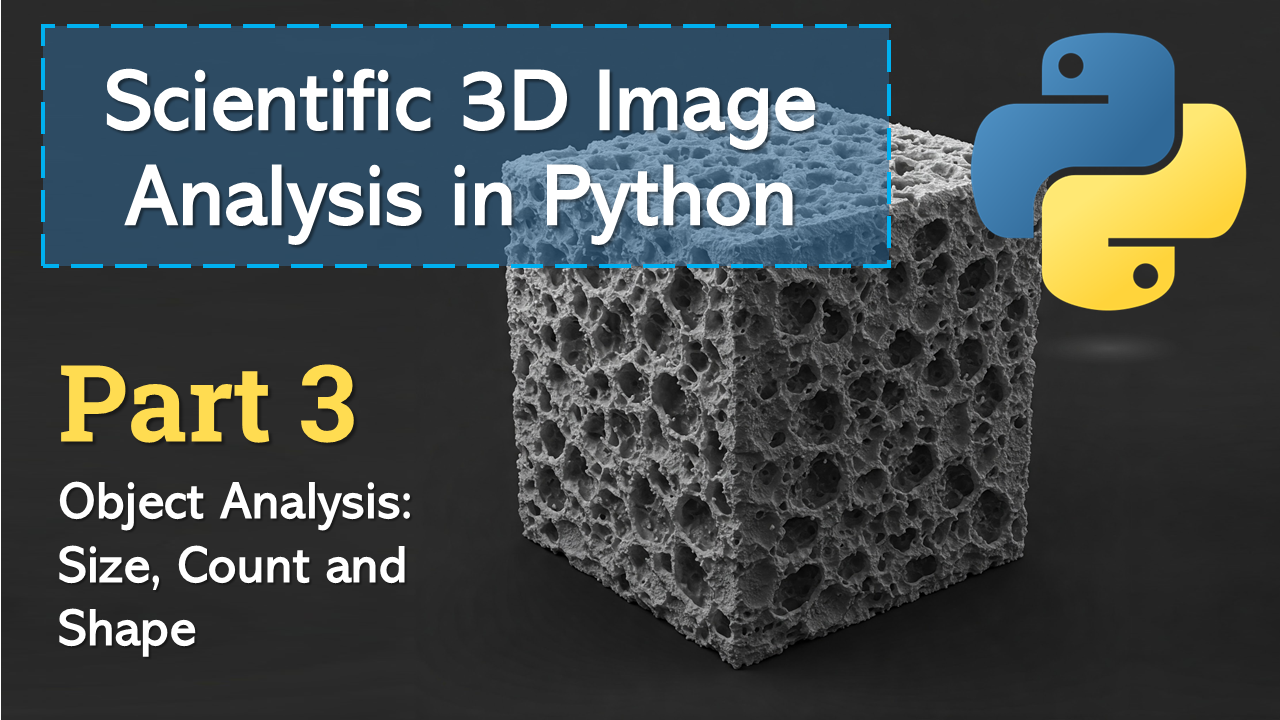
### What we'll cover:
- Volume and phase fraction calculations
- Surface area measurements
- Object separation techniques
  - Watershed segmentation
  - Superpixel segmentation
- Object size measurements
- Shape analysis
  - Sphericity
  - Aspect ratio
  - Orientation

Data source: https://www.digitalrocksportal.org/projects/324

## Import Required Libraries

In [2]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure, morphology, segmentation, filters, feature
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go
import time

## Load and Prepare the Image
We'll load our TIFF stack and prepare visualization functions

Loading and preparing data...


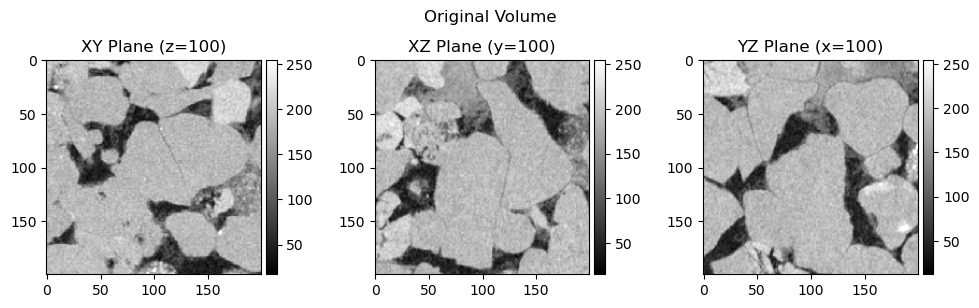

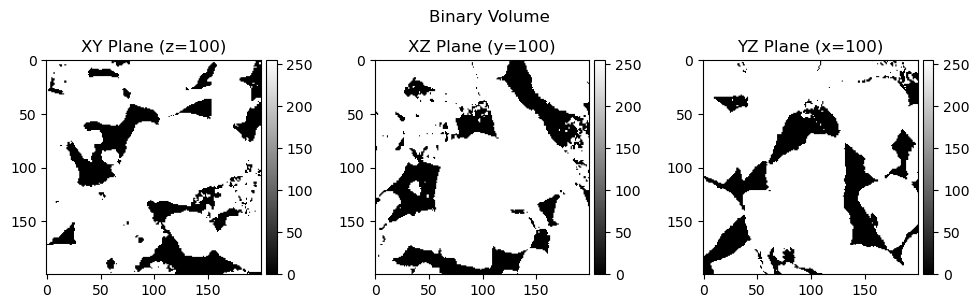

In [3]:
def plot_2d_slices(volume, title="2D Slices Visualization"):
    z_slice = volume.shape[0] // 2
    y_slice = volume.shape[1] // 2
    x_slice = volume.shape[2] // 2
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
    
    # XY plane (top view)
    im1 = ax1.imshow(volume[z_slice, :, :], cmap='gray')
    ax1.set_title(f'XY Plane (z={z_slice})')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax)
    
    # XZ plane
    im2 = ax2.imshow(volume[:, y_slice, :], cmap='gray')
    ax2.set_title(f'XZ Plane (y={y_slice})')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)
    
    # YZ plane
    im3 = ax3.imshow(volume[:, :, x_slice], cmap='gray')
    ax3.set_title(f'YZ Plane (x={x_slice})')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    plt.suptitle(title)
    plt.tight_layout()
    return fig

# Load and threshold the image
print("Loading and preparing data...")
image_path = '200-500-8bits.tif'
image_3d = tifffile.imread(image_path)
image_3d = image_3d[:200, :200, :200]  # Crop for faster processing

# Apply Otsu thresholding
thresh = filters.threshold_otsu(image_3d)
binary = image_3d > thresh

# Display original and binary images
plot_2d_slices(image_3d, "Original Volume")
plt.show()
plot_2d_slices(binary.astype(np.uint8) * 255, "Binary Volume")
plt.show()

## Volume and Phase Fraction Calculations
Calculate the volume of each phase and their relative proportions

In [4]:
def calculate_phase_fractions(binary_volume, voxel_size=5.22):
    """
    Calculate volume and phase fractions of a binary image
    voxel_size in micrometers
    """
    total_voxels = binary_volume.size
    phase1_voxels = np.sum(binary_volume)
    phase2_voxels = total_voxels - phase1_voxels
    
    # Calculate volumes in cubic micrometers
    voxel_volume = voxel_size**3
    total_volume = total_voxels * voxel_volume
    phase1_volume = phase1_voxels * voxel_volume
    phase2_volume = phase2_voxels * voxel_volume
    
    # Calculate fractions
    phase1_fraction = phase1_voxels / total_voxels
    phase2_fraction = phase2_voxels / total_voxels
    
    return {
        'total_volume': total_volume,
        'phase1_volume': phase1_volume,
        'phase2_volume': phase2_volume,
        'phase1_fraction': phase1_fraction,
        'phase2_fraction': phase2_fraction
    }

# Calculate and display results
results = calculate_phase_fractions(binary)
print("\nVolume Analysis Results:")
print(f"Total Volume: {results['total_volume']:.2f} μm³")
print(f"Phase 1 Volume: {results['phase1_volume']:.2f} μm³")
print(f"Phase 2 Volume: {results['phase2_volume']:.2f} μm³")
print(f"Phase 1 Fraction: {results['phase1_fraction']:.3f}")
print(f"Phase 2 Fraction: {results['phase2_fraction']:.3f}")


Volume Analysis Results:
Total Volume: 1137893184.00 μm³
Phase 1 Volume: 948030301.26 μm³
Phase 2 Volume: 189862882.74 μm³
Phase 1 Fraction: 0.833
Phase 2 Fraction: 0.167


## Surface Area Measurements
Calculate the surface area between phases using a marching cubes algorithm

In [5]:
from skimage import measure

def calculate_surface_area(binary_volume, voxel_size=5.22):
    """
    Calculate surface area and specific surface area using marching cubes algorithm
    voxel_size in micrometers
    """
    # First, get total volume of the solid phase
    solid_voxels = np.sum(binary_volume)
    total_volume_um3 = solid_voxels * (voxel_size**3)
    total_volume_cm3 = total_volume_um3 * 1e-12  # Convert μm³ to cm³
    
    # Calculate surface using marching cubes
    verts, faces, _, _ = measure.marching_cubes(binary_volume)
    
    # Scale vertices by voxel size
    verts = verts * voxel_size  # Scale vertices by voxel size
    surface_area_um2 = measure.mesh_surface_area(verts, faces)
    surface_area_m2 = surface_area_um2 * 1e-12  # Convert μm² to m²
    
    # Calculate specific surface area (area per volume)
    specific_surface_area_volume = surface_area_um2 / total_volume_um3  # μm²/μm³ = 1/μm
    
    # Calculate specific surface area in standard units
    specific_surface_area_m2_cm3 = surface_area_m2 / (total_volume_cm3)  # m²/cm³
    
    # Calculate mass-based SSA if density is known (2.65 g/cm³ for quartz)
    density = 2.65  # g/cm³
    mass = total_volume_cm3 * density  # g
    specific_surface_area_m2_g = surface_area_m2 / mass  # m²/g
    
    return {
        'surface_area_um2': surface_area_um2,
        'total_volume_um3': total_volume_um3,
        'specific_surface_area_um': specific_surface_area_volume,
        'specific_surface_area_m2_cm3': specific_surface_area_m2_cm3,
        'specific_surface_area_m2_g': specific_surface_area_m2_g
    }

# Calculate surface area
results = calculate_surface_area(binary)
print(f"\nSurface Area: {results['surface_area_um2']:.2f} μm²")
print(f"Total Solid Volume: {results['total_volume_um3']:.2f} μm³")
print(f"Specific Surface Area (volume-based): {results['specific_surface_area_um']:.4f} μm⁻¹")
print(f"Specific Surface Area: {results['specific_surface_area_m2_cm3']:.4f} m²/cm³")
print(f"Specific Surface Area (mass-based): {results['specific_surface_area_m2_g']:.4f} m²/g")


Surface Area: 14310541.00 μm²
Total Solid Volume: 948030301.26 μm³
Specific Surface Area (volume-based): 0.0151 μm⁻¹
Specific Surface Area: 0.0151 m²/cm³
Specific Surface Area (mass-based): 0.0057 m²/g


## Object Separation
Implement watershed and superpixel segmentation to separate connected objects


Separating objects...


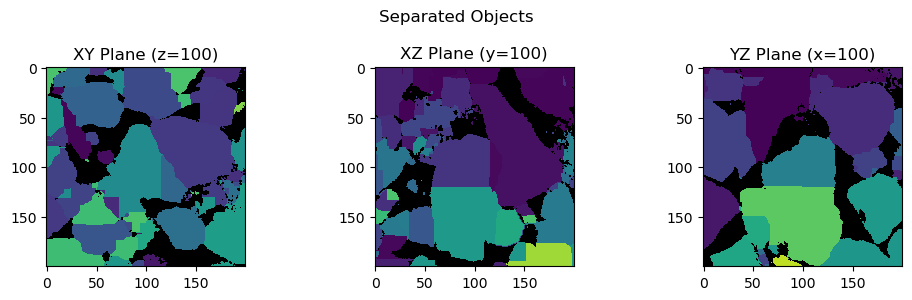

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure, morphology, segmentation, filters, feature
import random
from matplotlib.colors import ListedColormap

def separate_objects(binary_volume):
    """
    Separate connected objects using watershed segmentation
    """
    # Distance transform
    distance = ndimage.distance_transform_edt(binary_volume)
    # Smoothing the distance map
    distance = ndimage.gaussian_filter(distance, sigma=2)
    
    # Find local maxima
    local_max = feature.peak_local_max(
        distance,
        footprint=np.ones((3, 3, 3)),
        labels=binary_volume
    )
    
    # Create markers for watershed
    markers = np.zeros_like(distance, dtype=bool)
    markers[tuple(local_max.T)] = True
    markers = measure.label(markers)
    
    # Watershed segmentation
    labels = segmentation.watershed(-distance, markers, mask=binary_volume)
    
    return labels

# Separate objects
print("\nSeparating objects...")
separated_objects = separate_objects(binary)

# Create shuffled viridis colormap with black background
viridis = plt.cm.viridis
colors = viridis(np.linspace(0, 1, 256))
colors[0] = [0, 0, 0, 1]  # Make background black
random.shuffle(colors[1:])  # Shuffle all colors except background
label_cmap = ListedColormap(colors)

# Plot with custom colormap
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(separated_objects[separated_objects.shape[0]//2, :, :], cmap=label_cmap)
plt.title(f'XY Plane (z={separated_objects.shape[0]//2})')
plt.subplot(132)
plt.imshow(separated_objects[:, separated_objects.shape[1]//2, :], cmap=label_cmap)
plt.title(f'XZ Plane (y={separated_objects.shape[1]//2})')
plt.subplot(133)
plt.imshow(separated_objects[:, :, separated_objects.shape[2]//2], cmap=label_cmap)
plt.title(f'YZ Plane (x={separated_objects.shape[2]//2})')
plt.suptitle("Separated Objects")
plt.tight_layout()
plt.show()

## Object Size Measurements
Analyze the size distribution of separated objects

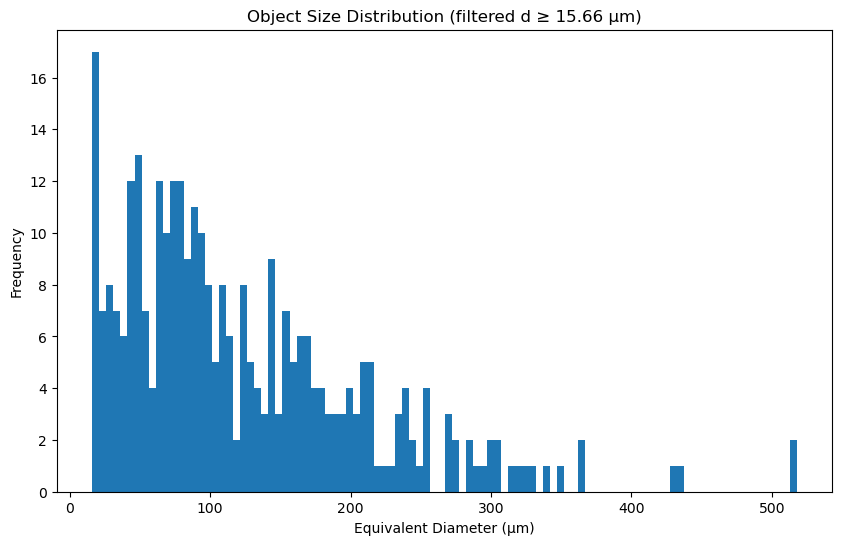


Object Analysis:
Number of objects (after filtering): 318
Objects excluded: 383
Mean volume: 2980230.81 μm³
Median volume: 483675.72 μm³
Min volume: 2133.55 μm³
Max volume: 72672686.09 μm³
Mean equivalent diameter: 123.42 μm
Median equivalent diameter: 97.39 μm
Min equivalent diameter: 15.97 μm
Max equivalent diameter: 517.75 μm


In [7]:
def analyze_object_sizes(labeled_volume, voxel_size=5.22, min_diameter_factor=3):
    """
    Measure sizes of labeled objects
    Returns volumes in cubic micrometers and equivalent diameters in micrometers
    Excludes objects with diameter < min_diameter_factor * voxel_size
    """
    # Get object properties
    props = measure.regionprops(labeled_volume)
    
    # Calculate volumes
    all_volumes = [prop.area * voxel_size**3 for prop in props]
    
    # Calculate equivalent diameters (diameter of sphere with same volume)
    all_eq_diameters = [(6 * volume / np.pi) ** (1/3) for volume in all_volumes]
    
    # Filter objects based on diameter threshold
    min_diameter = min_diameter_factor * voxel_size
    filtered_indices = [i for i, diameter in enumerate(all_eq_diameters) if diameter >= min_diameter]
    
    volumes = [all_volumes[i] for i in filtered_indices]
    eq_diameters = [all_eq_diameters[i] for i in filtered_indices]
    
    return volumes, eq_diameters

# Calculate object sizes with filtering
volumes, eq_diameters = analyze_object_sizes(separated_objects, voxel_size=5.22, min_diameter_factor=3)

# Plot equivalent diameter distribution
plt.figure(figsize=(10, 6))
plt.hist(eq_diameters, bins=100)
plt.xlabel('Equivalent Diameter (μm)')
plt.ylabel('Frequency')
plt.title('Object Size Distribution (filtered d ≥ {:.2f} μm)'.format(3 * 5.22))
plt.show()

print(f"\nObject Analysis:")
print(f"Number of objects (after filtering): {len(volumes)}")
print(f"Objects excluded: {len(measure.regionprops(separated_objects)) - len(volumes)}")
print(f"Mean volume: {np.mean(volumes):.2f} μm³")
print(f"Median volume: {np.median(volumes):.2f} μm³")
print(f"Min volume: {np.min(volumes):.2f} μm³")
print(f"Max volume: {np.max(volumes):.2f} μm³")
print(f"Mean equivalent diameter: {np.mean(eq_diameters):.2f} μm")
print(f"Median equivalent diameter: {np.median(eq_diameters):.2f} μm")
print(f"Min equivalent diameter: {np.min(eq_diameters):.2f} μm")
print(f"Max equivalent diameter: {np.max(eq_diameters):.2f} μm")

## Shape Analysis
Calculate shape descriptors for each object

Data exported to object_properties.xlsx


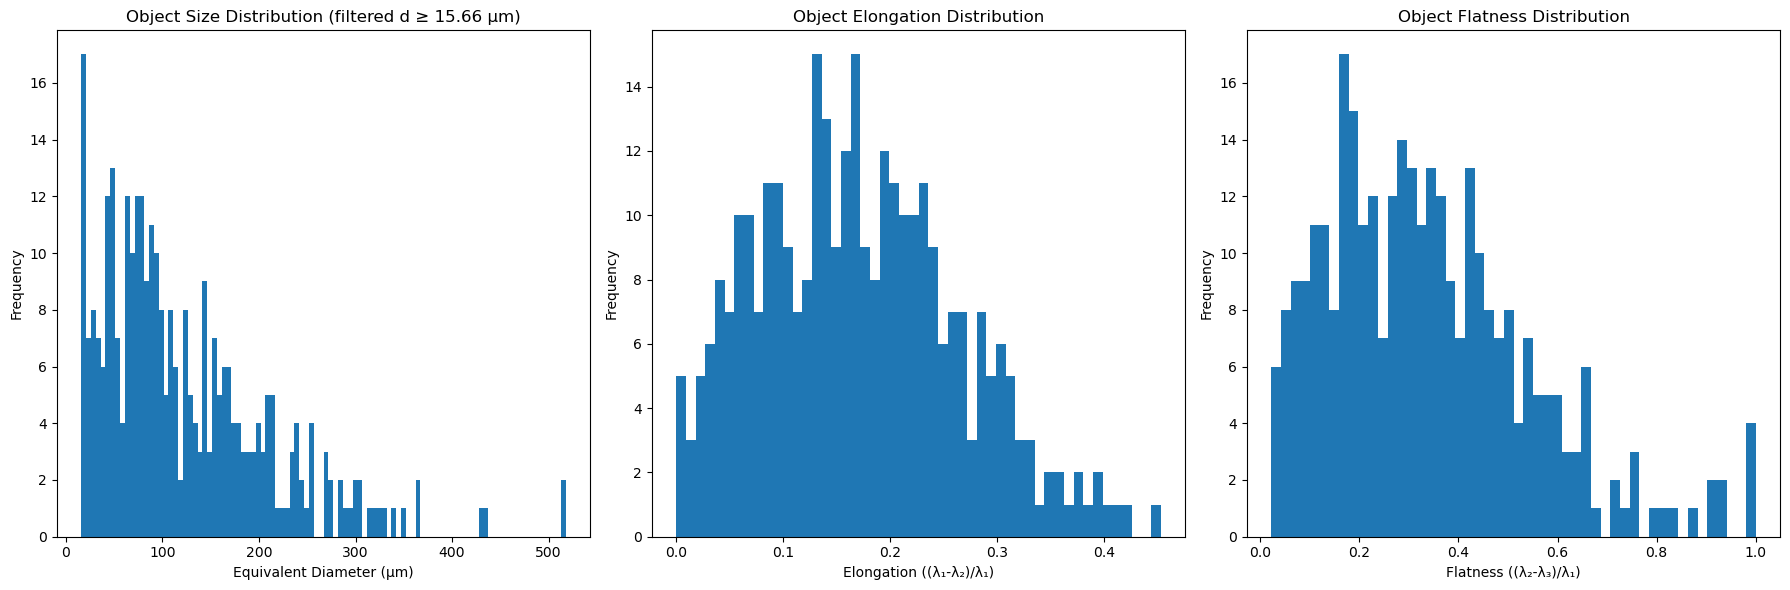


Object Analysis:
Number of objects (after filtering): 318
Objects excluded: 383
Mean volume: 2980230.81 μm³
Median volume: 483675.72 μm³
Min volume: 2133.55 μm³
Max volume: 72672686.09 μm³
Mean equivalent diameter: 123.42 μm
Median equivalent diameter: 97.39 μm
Min equivalent diameter: 15.97 μm
Max equivalent diameter: 517.75 μm
Mean elongation: 0.17
Median elongation: 0.16
Mean flatness: 0.34
Median flatness: 0.31


In [15]:
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
import pandas as pd

def analyze_object_sizes(labeled_volume, voxel_size=5.22, min_diameter_factor=3, export_excel=True, filename='object_properties.xlsx'):
    """
    Measure sizes of labeled objects in 3D volumes
    Returns volumes in cubic micrometers and equivalent diameters in micrometers
    Excludes objects with diameter < min_diameter_factor * voxel_size
    Exports properties to Excel file
    """
    # Get object properties
    props = measure.regionprops(labeled_volume)
    
    # Create data structure for all objects
    data = []
    for i, prop in enumerate(props):
        # Calculate volume and equivalent diameter
        volume = prop.area * voxel_size**3
        eq_diameter = (6 * volume / np.pi) ** (1/3)
        
        # Get eigenvalues and compute shape metrics
        eigenvalues = prop.inertia_tensor_eigvals
        # Sort eigenvalues in descending order (largest to smallest)
        sorted_eigenvals = np.sort(eigenvalues)[::-1]  # Descending order
        
        # Apply the specified formulas
        if sorted_eigenvals[0] > 0:  # Ensure λ1 > 0 to avoid division by zero
            # Flatness = (λ2 - λ3) / λ1
            flatness = (sorted_eigenvals[1] - sorted_eigenvals[2]) / sorted_eigenvals[0]
            
            # Elongation = (λ1 - λ2) / λ1
            elongation = (sorted_eigenvals[0] - sorted_eigenvals[1]) / sorted_eigenvals[0]
        else:
            flatness = np.nan
            elongation = np.nan
        
        # Store properties in dictionary - using only 3D-compatible properties
        obj_data = {
            'Label': prop.label,
            'Volume (μm³)': volume,
            'Equivalent Diameter (μm)': eq_diameter,
            'Centroid_Z': prop.centroid[0],
            'Centroid_Y': prop.centroid[1],
            'Centroid_X': prop.centroid[2] if len(prop.centroid) > 2 else None,
            'Area (voxels)': prop.area,
            'Bbox_min_Z': prop.bbox[0],
            'Bbox_min_Y': prop.bbox[1],
            'Bbox_min_X': prop.bbox[2] if len(prop.bbox) > 4 else None,
            'Bbox_max_Z': prop.bbox[3],
            'Bbox_max_Y': prop.bbox[4],
            'Bbox_max_X': prop.bbox[5] if len(prop.bbox) > 4 else None,
            'Extent': prop.extent,
            'Inertia_tensor_eigenvalues': [str(val) for val in prop.inertia_tensor_eigvals],
            'Elongation': elongation,
            'Flatness': flatness
        }
        data.append(obj_data)
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Apply filtering
    min_diameter = min_diameter_factor * voxel_size
    filtered_df = df[df['Equivalent Diameter (μm)'] >= min_diameter]
    
    # Export to Excel if requested
    if export_excel:
        with pd.ExcelWriter(filename) as writer:
            df.to_excel(writer, sheet_name='All Objects', index=False)
            filtered_df.to_excel(writer, sheet_name='Filtered Objects', index=False)
        print(f"Data exported to {filename}")
    
    # Extract volumes, diameters, and shape metrics for filtered objects
    volumes = filtered_df['Volume (μm³)'].tolist()
    eq_diameters = filtered_df['Equivalent Diameter (μm)'].tolist()
    elongations = filtered_df['Elongation'].dropna().tolist()
    flatnesses = filtered_df['Flatness'].dropna().tolist()
    
    return volumes, eq_diameters, elongations, flatnesses, df, filtered_df

# Calculate object sizes with filtering and export to Excel
volumes, eq_diameters, elongations, flatnesses, all_objects_df, filtered_objects_df = analyze_object_sizes(
    separated_objects, voxel_size=5.22, min_diameter_factor=3, export_excel=True, filename='object_properties.xlsx')

# Create subplot figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Size (Equivalent Diameter) Distribution
axs[0].hist(eq_diameters, bins=100)
axs[0].set_xlabel('Equivalent Diameter (μm)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Object Size Distribution (filtered d ≥ {:.2f} μm)'.format(3 * 5.22))

# Plot 2: Elongation Distribution
axs[1].hist(elongations, bins=50)
axs[1].set_xlabel('Elongation ((λ₁-λ₂)/λ₁)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Object Elongation Distribution')

# Plot 3: Flatness Distribution
axs[2].hist(flatnesses, bins=50)
axs[2].set_xlabel('Flatness ((λ₂-λ₃)/λ₁)')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Object Flatness Distribution')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nObject Analysis:")
print(f"Number of objects (after filtering): {len(volumes)}")
print(f"Objects excluded: {len(all_objects_df) - len(filtered_objects_df)}")
print(f"Mean volume: {np.mean(volumes):.2f} μm³")
print(f"Median volume: {np.median(volumes):.2f} μm³")
print(f"Min volume: {np.min(volumes):.2f} μm³")
print(f"Max volume: {np.max(volumes):.2f} μm³")
print(f"Mean equivalent diameter: {np.mean(eq_diameters):.2f} μm")
print(f"Median equivalent diameter: {np.median(eq_diameters):.2f} μm")
print(f"Min equivalent diameter: {np.min(eq_diameters):.2f} μm")
print(f"Max equivalent diameter: {np.max(eq_diameters):.2f} μm")
print(f"Mean elongation: {np.mean(elongations):.2f}")
print(f"Median elongation: {np.median(elongations):.2f}")
print(f"Mean flatness: {np.mean(flatnesses):.2f}")
print(f"Median flatness: {np.median(flatnesses):.2f}")